## Outpatient monitoring and management of insulin-dependent diabetes mellitus (IDDM)

### Problem : 

Insulin-dependent diabetes mellitus, now known as diabetes mellitus type 1, an autoimmune disease resulting in the destruction of insulin-producing cells.
Patients with IDDM are insulin deficient. This can either be due to a)
low or absent production of insulin by the beta islet cells of the
pancreas subsequent to an auto-immune attack or b) insulin-resistance,
typically associated with older age and obesity, which leads to a
relative insulin-deficiency even though the insulin levels might be
normal.

Regardless of cause, the lack of adequate insulin effect has multiple
metabolic effects. However, once a patient is diagnosed and is
receiving regularly scheduled exogenous (externally administered)
insulin, the principal metabolic effect of concern is the potential
for hyperglycemia (high blood glucose). Chronic hyperglycemia over a
period of several years puts a patient at risk for several kinds of
micro and macrovascular problems (e.g. retinopathy). Consequently, the
goal of therapy for IDDM is to bring the average blood glucose as close
to the normal range as possible. As explained below, current therapy
makes this goal a very challenging (and often frustrating) one for
most patients. One important consideration is that due to the
inevitable variation of blood glucose (BG) around the mean, a lower mean
will result in a higher frequency of unpleasant and sometimes
dangerous low BG levels.


**Outpatient management :**

Outpatient management of IDDM relies principally on three
interventions: diet, excercise and exogenous insulin. Proper treatment
requires careful consideration of all three interventions. 



### Objectives

Our goal in this project is to use machine learning techniques to classify patients into one of the following categories:

**1.hyperglycemia (When the average blood glucose level exceeds 200 over several years.)**

**2.hypoglycemia (low BG) symptoms fall into two classes. Between 40-80 mg/dl**

**3.normal** : 

    A normal pre-meal BG ranges approximately 80-120 mg/dl. 
    A normal post-meal BG ranges 80-140 mg/dl. 
    The target range for an individual with diabetes mellitus is very controversial.
    I will cut the Gordian knot on this issue by noting that it would be very desirable to keep 90% of all BG 
    measurements < 200 mg/dl and that the average BG should be 150 mg/dl or less. 
    Source : Domain-Description


So that patients can receive the appropriate treatment, Because the aim of Type I diabetes treatment (IDDM) is to bring average blood sugar levels as close as possible to the normal range.
 

**Importing modules**

In [958]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score,mean_absolute_error
import os
import glob
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

### I.Data preparation

#### I.1 Import data

    Domain Description: The data used in this project describes the physiology and patho-
    physiology of diabetes mellitus and its treatment.

    data-[01-70]: datasets spanning several weeks to several months
    outpatient care for 70 patients.
    
    File Names and format:
    (1) Date in MM-DD-YYYY format
    (2) Time in XX:YY format
    (3) Code
    (4) Value

    The Code field is deciphered as follows:

    33 = Regular insulin dose
    34 = NPH insulin dose
    35 = UltraLente insulin dose
    48 = Unspecified blood glucose measurement
    57 = Unspecified blood glucose measurement
    58 = Pre-breakfast blood glucose measurement
    59 = Post-breakfast blood glucose measurement
    60 = Pre-lunch blood glucose measurement
    61 = Post-lunch blood glucose measurement
    62 = Pre-supper blood glucose measurement
    63 = Post-supper blood glucose measurement
    64 = Pre-snack blood glucose measurement
    65 = Hypoglycemic symptoms
    66 = Typical meal ingestion
    67 = More-than-usual meal ingestion
    68 = Less-than-usual meal ingestion
    69 = Typical exercise activity
    70 = More-than-usual exercise activity
    71 = Less-than-usual exercise activity
    72 = Unspecified special event

In [959]:
import os
import csv

def combine_files(folder_path, output_file):
    # List all files in the folder
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    
    # Open output CSV file
    with open(output_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        
        # Write headers
        writer.writerow(["ID", "Date", "Time", "Code", "Value"])
        
        # Iterate through each file
        for idx, file_name in enumerate(files, start=1):
            file_path = os.path.join(folder_path, file_name)
            # Open and read each file
            with open(file_path, 'r') as file:
                for line in file:
                    # Split the line by tab and write to CSV
                    writer.writerow([idx] + line.strip().split('\t'))

# Example usage
folder_path = r"C:\Users\DELL 7430\Downloads\Diabetes_Project\data\Diabetes-Data"
output_file = 'combined_data.csv'
combine_files(folder_path, output_file)


In [960]:
#This dataframe contains all the files for all seventy patients.
diabete_df = pd.read_csv(r"C:\Users\DELL 7430\Downloads\Diabetes_Project\diabetes-data\Diabetes-Data\combined_data.csv")

In [961]:
diabete_df

ID        Date   Time Code Value
0       1  04-21-1991   9:09   58   100
1       1  04-21-1991   9:09   33   009
2       1  04-21-1991   9:09   34   013
3       1  04-21-1991  17:08   62   119
4       1  04-21-1991  17:08   33   007
...    ..         ...    ...  ...   ...
29325  70  05-09-1989  08:00   33   001
29326  70  05-09-1989  08:00   34   007
29327  70  05-10-1989  08:00   34   007
29328  70  05-11-1989  08:00   34   007
29329  70  05-12-1989  08:00   34   007

[29330 rows x 5 columns]

**In this project, we're interested in blood glucose levels, 
so we're going to get the codes that measure this.**

In [962]:
#Filter down to blood glucose measurements only.
df_bg = diabete_df[diabete_df['Code'].str.contains('48|57|58|59|60|61|62|63|64',regex=True)]

In [963]:
df_bg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13531 entries, 0 to 29324
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      13531 non-null  int64 
 1   Date    13531 non-null  object
 2   Time    13531 non-null  object
 3   Code    13531 non-null  object
 4   Value   13531 non-null  object
dtypes: int64(1), object(4)
memory usage: 634.3+ KB


#### I.2 Data exploration

In [964]:
#convert value column to integer.
pd.options.mode.copy_on_write = True 
df_bg['Value'] = pd.to_numeric(df_bg['Value'],errors='coerce')
#diabete_df['Code'] = pd.to_numeric(diabete_df['Code'],errors='coerce')

In [965]:
df_bg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13531 entries, 0 to 29324
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      13531 non-null  int64  
 1   Date    13531 non-null  object 
 2   Time    13531 non-null  object 
 3   Code    13531 non-null  object 
 4   Value   13523 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 634.3+ KB


In [966]:
#Gotta clean up that dirty data.
#diabete_df['Value'].isnull().sum()/len(diabete_df)
df_bg = df_bg[df_bg['Value'].notnull()]

In [967]:
#For this project, we will transform the Date column 
#and the Time column into a single datetime column.
df_bg['timestamp'] = df_bg['Date'] + ' ' + df_bg['Time']
df_bg['datetime'] = pd.to_datetime(df_bg['timestamp'],errors="coerce")
#Remove NAN Rows
df_bg = df_bg[df_bg['datetime'].notnull()]

In [968]:
df_bg = df_bg.set_index('datetime')
df_bg = df_bg.sort_index()

In [969]:
df_bg.index

DatetimeIndex(['1988-03-27 08:00:00', '1988-03-27 12:00:00',
               '1988-03-27 18:00:00', '1988-03-28 08:00:00',
               '1988-03-28 12:00:00', '1988-03-28 18:00:00',
               '1988-03-31 08:00:00', '1988-03-31 12:00:00',
               '1988-03-31 18:00:00', '1988-04-02 08:00:00',
               ...
               '1991-09-21 14:30:00', '1991-09-21 19:50:00',
               '1991-09-22 08:35:00', '1991-09-22 11:30:00',
               '1991-09-22 17:45:00', '1991-09-22 22:15:00',
               '1991-09-23 07:45:00', '1991-09-23 12:15:00',
               '1991-09-23 17:15:00', '1991-09-23 21:10:00'],
              dtype='datetime64[ns]', name='datetime', length=13518, freq=None)

In [970]:
#df_bg.isnull().sum()

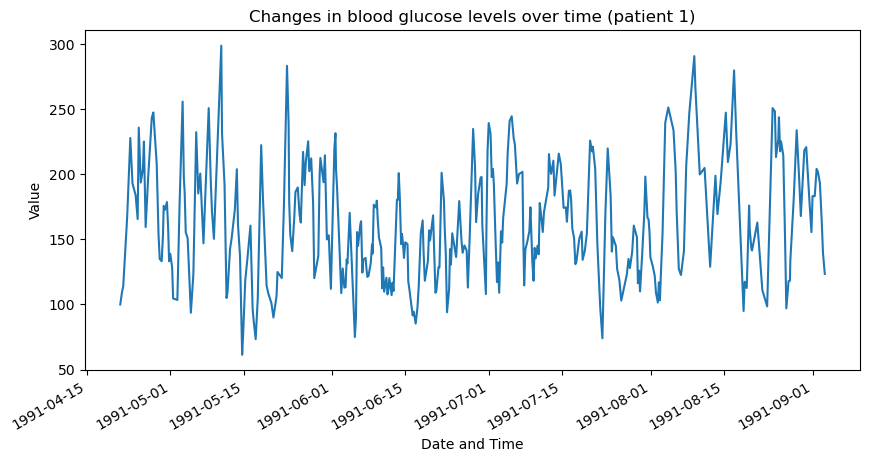

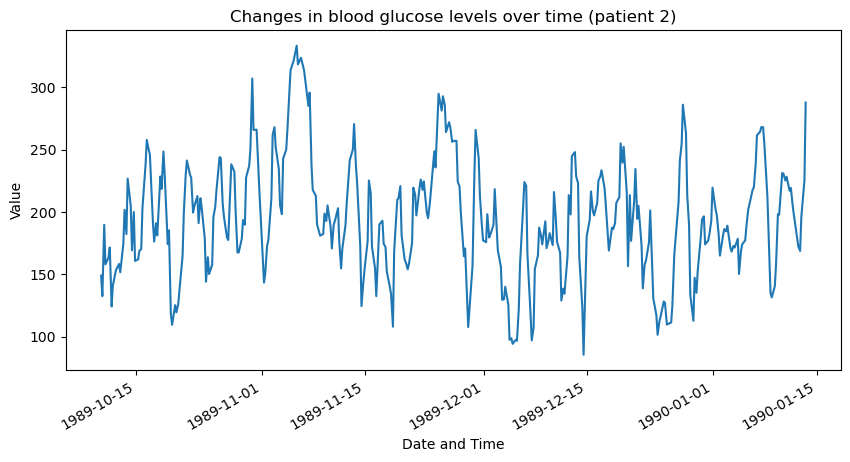

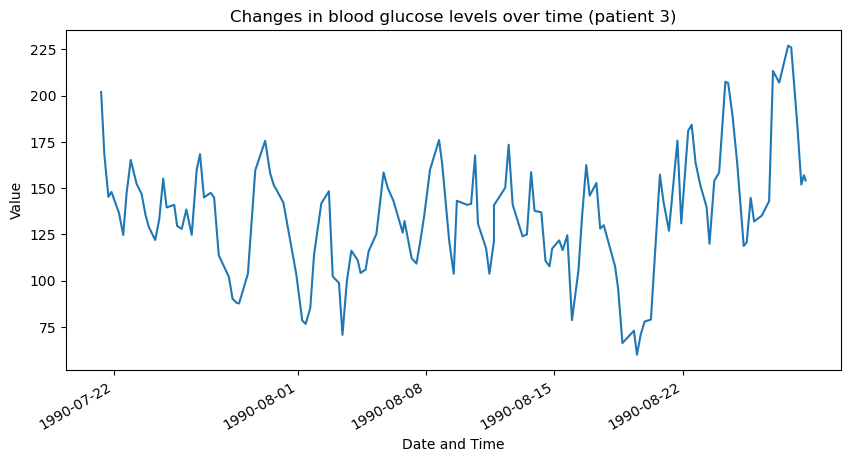

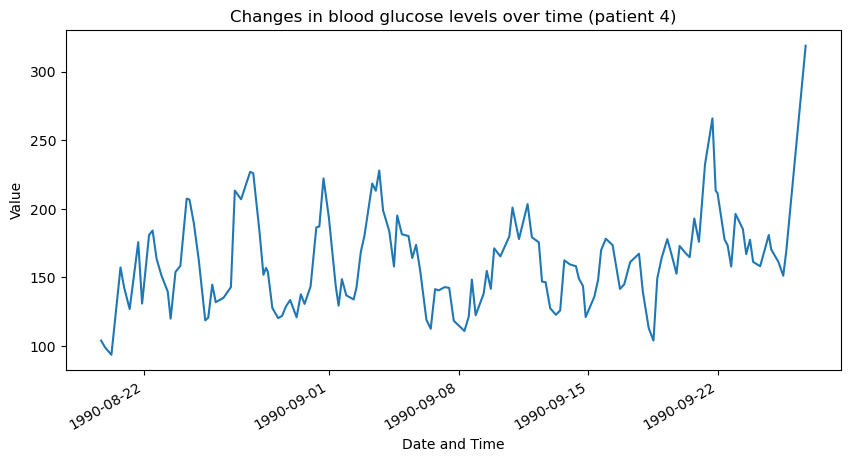

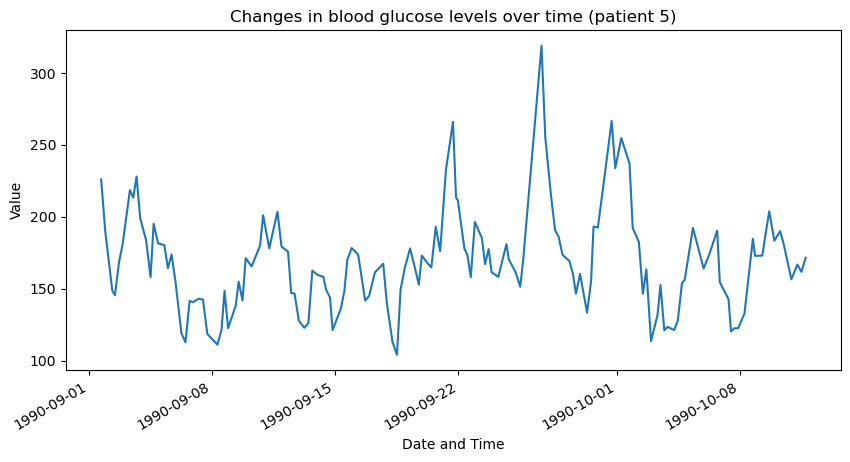

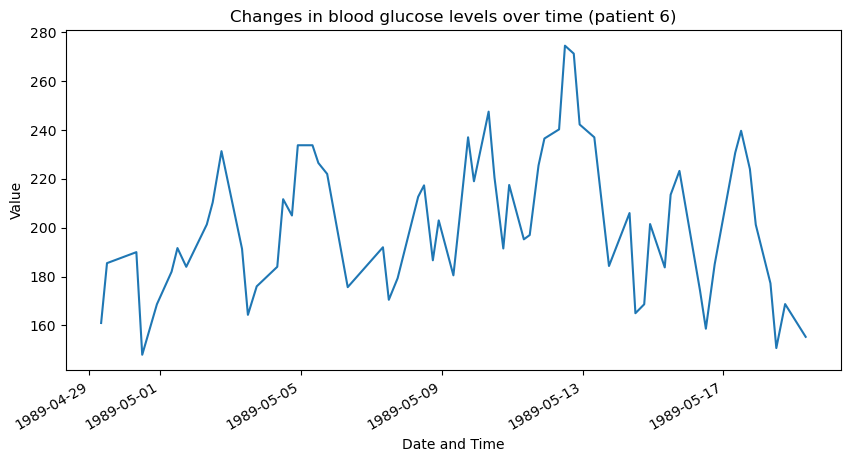

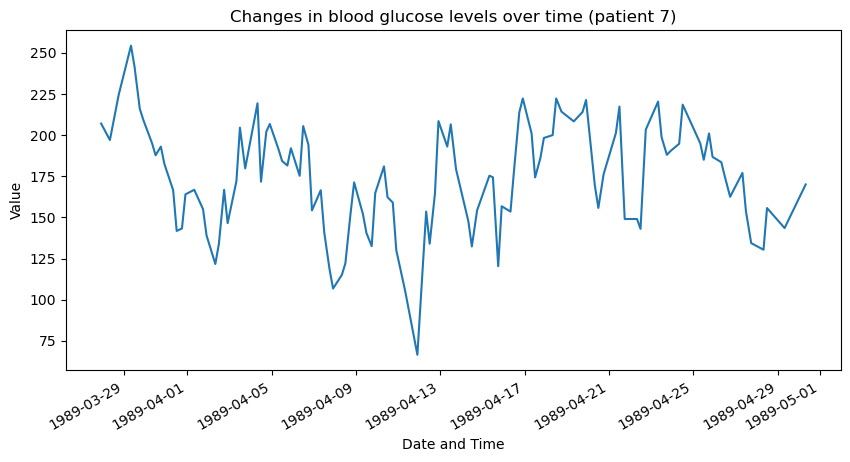

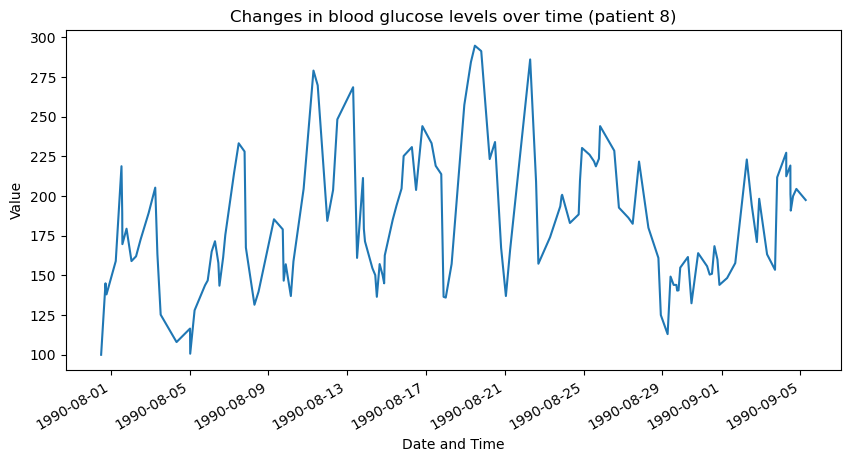

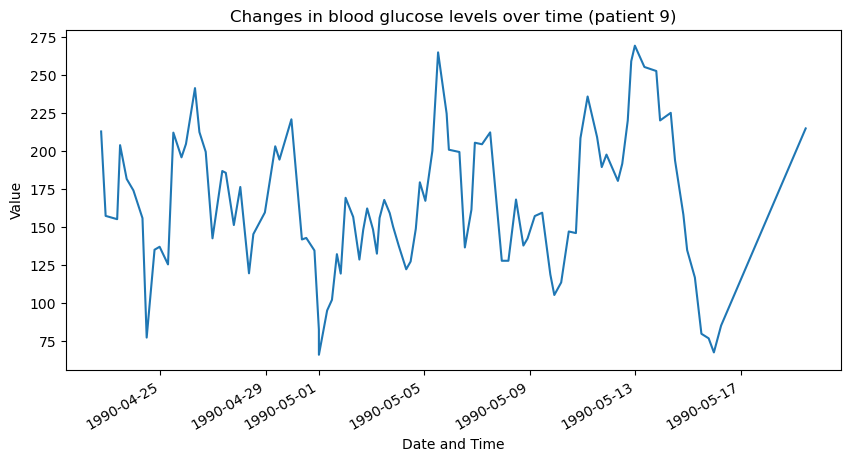

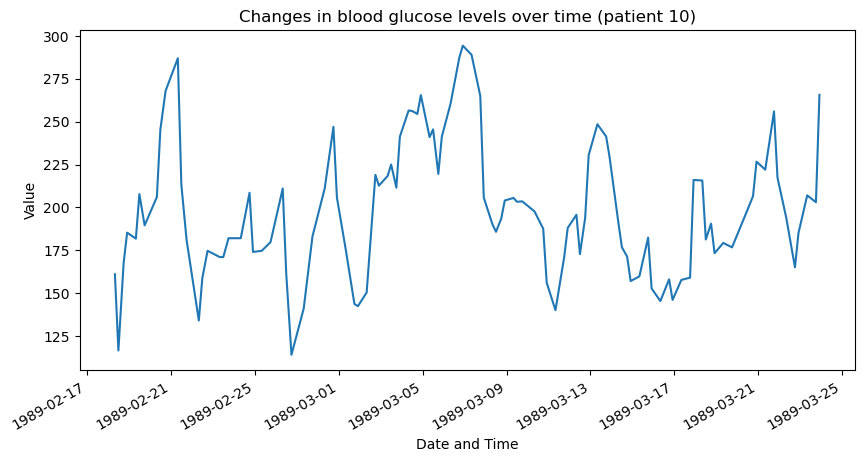

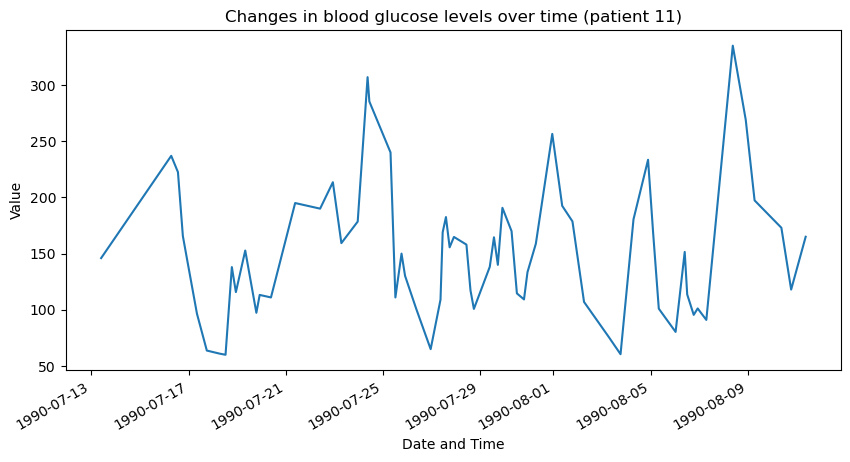

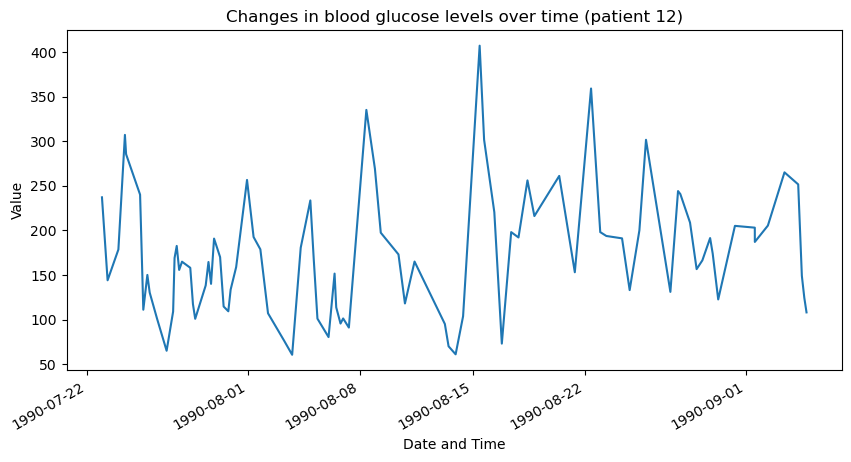

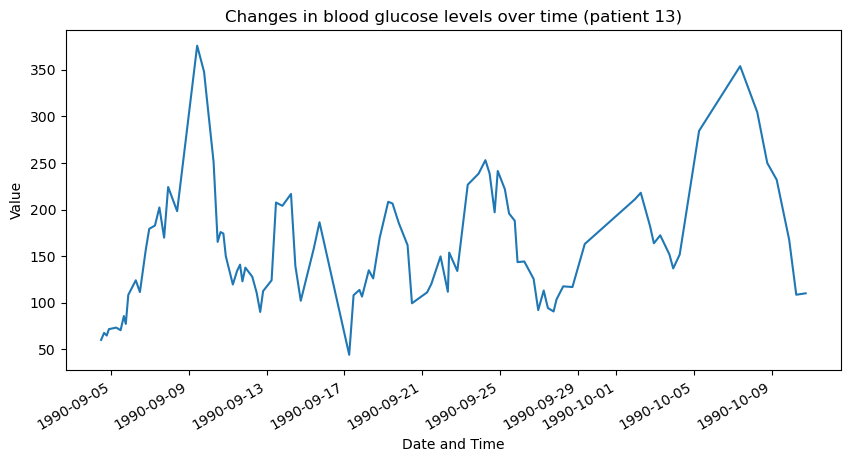

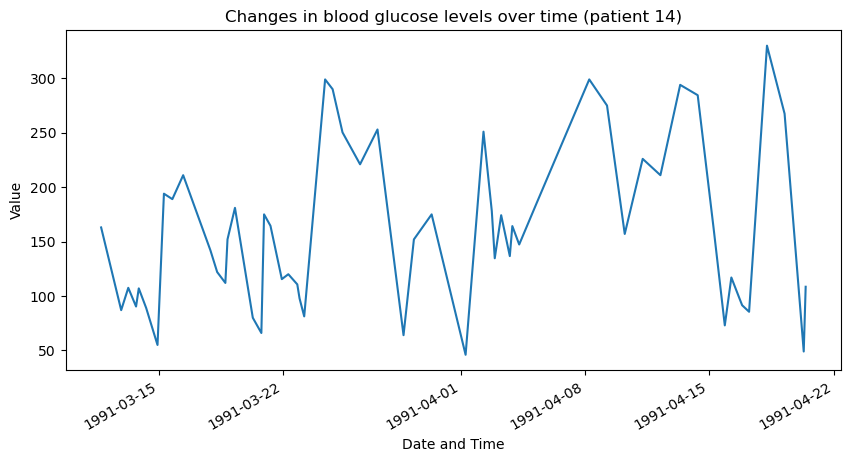

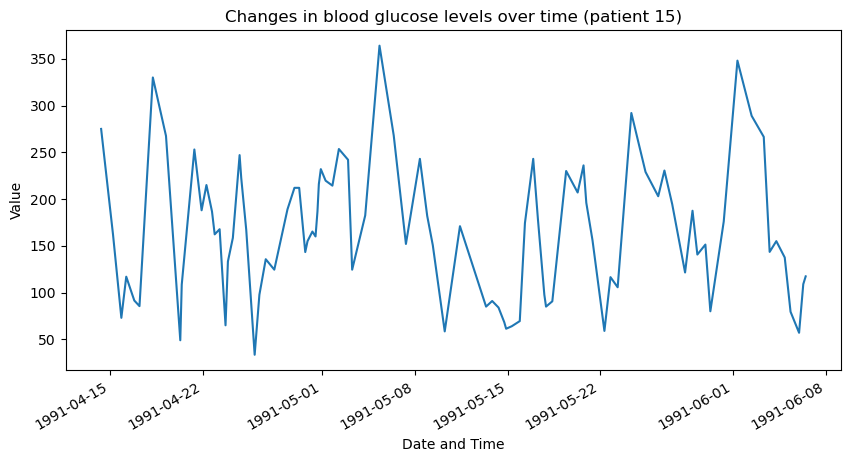

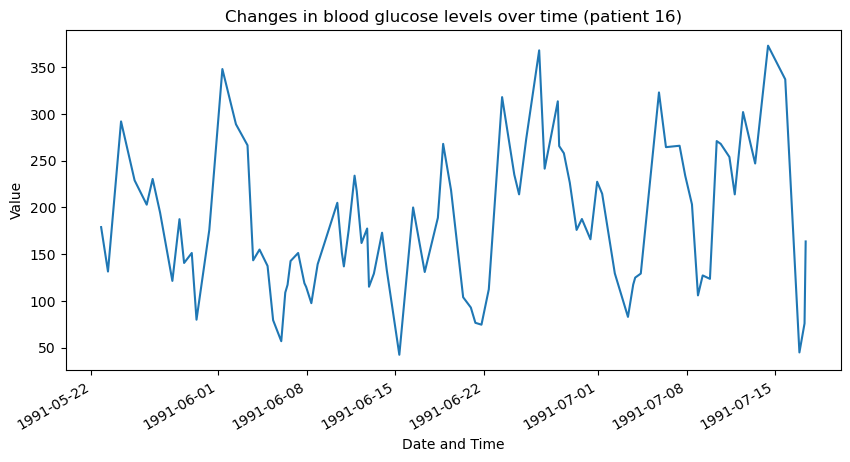

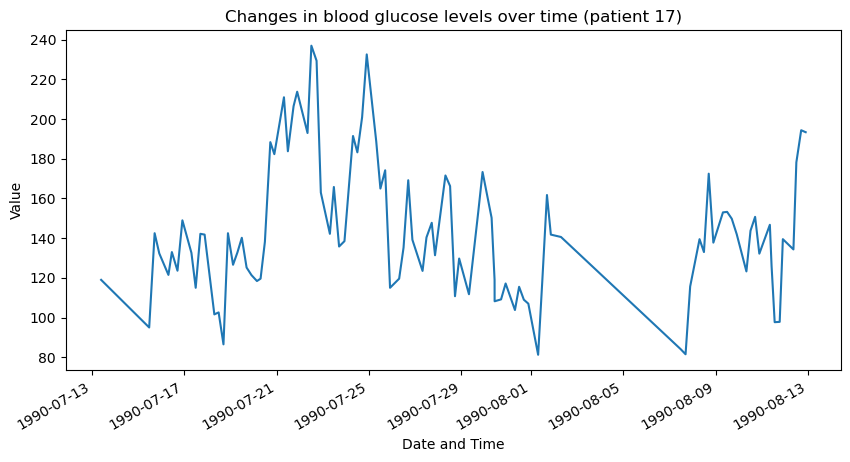

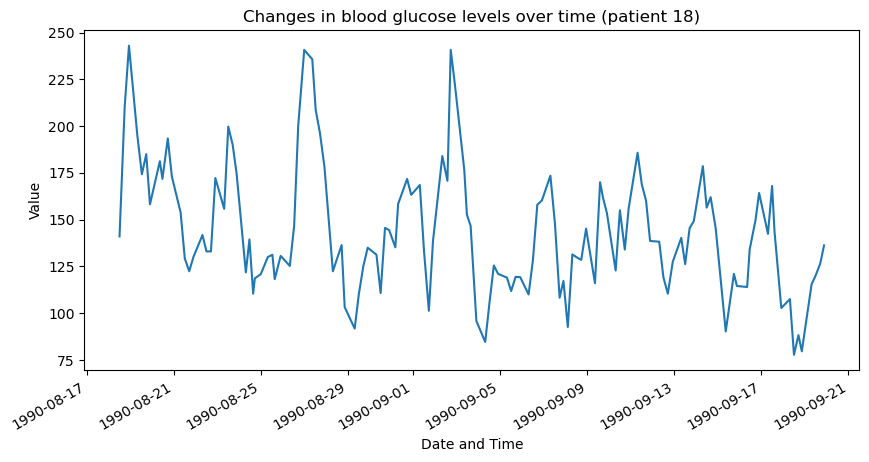

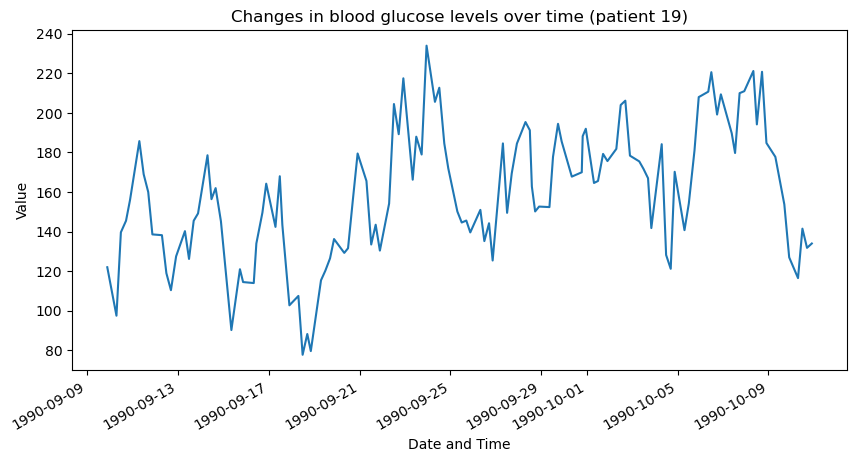

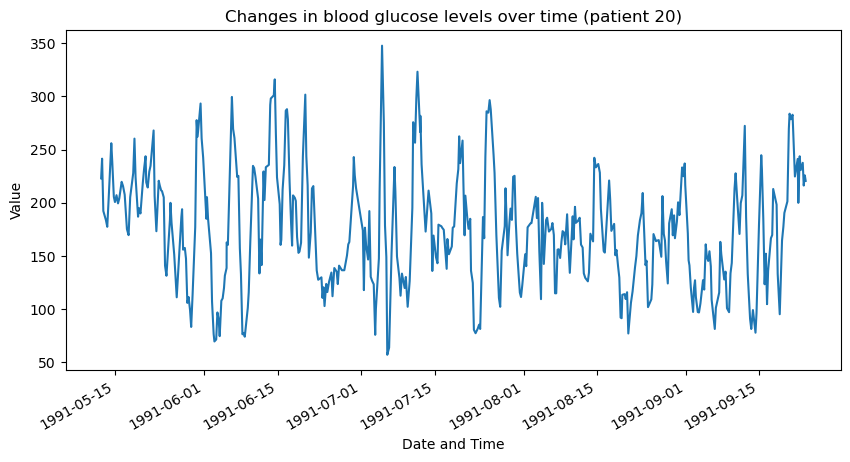

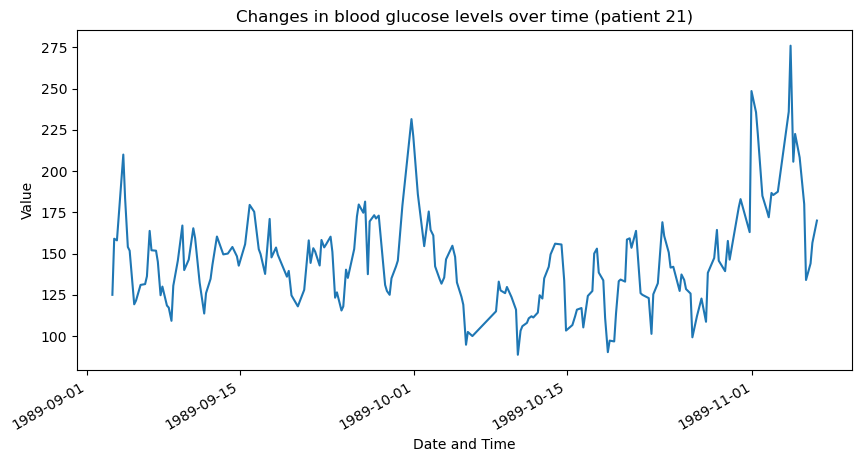

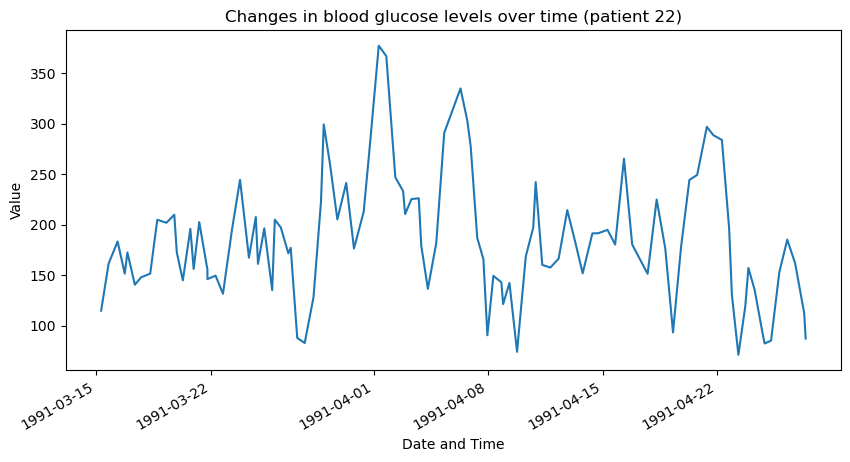

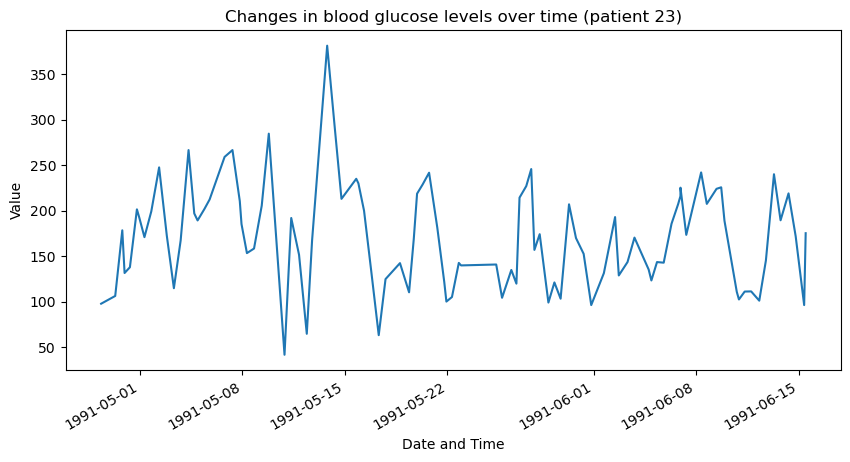

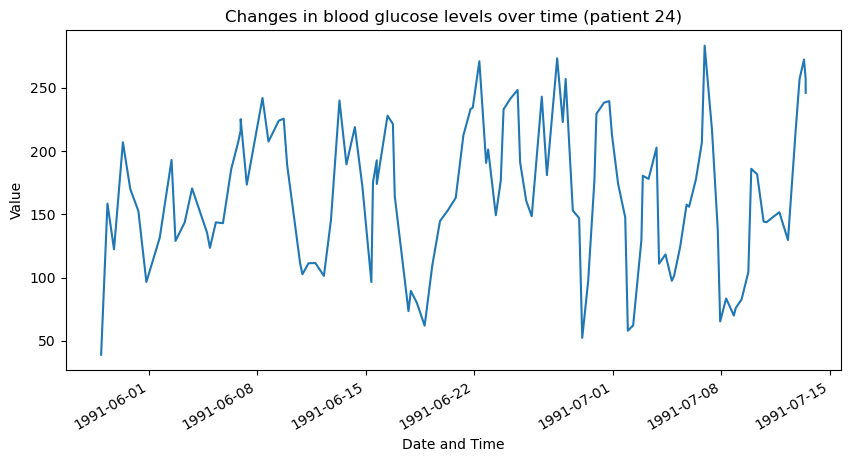

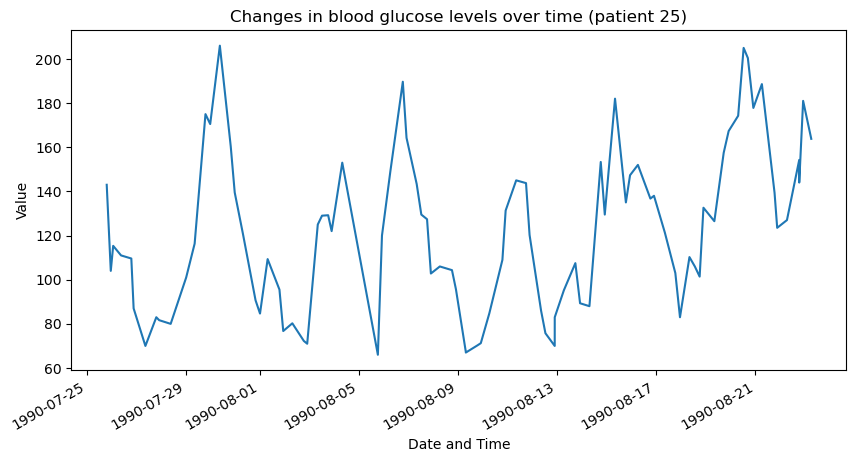

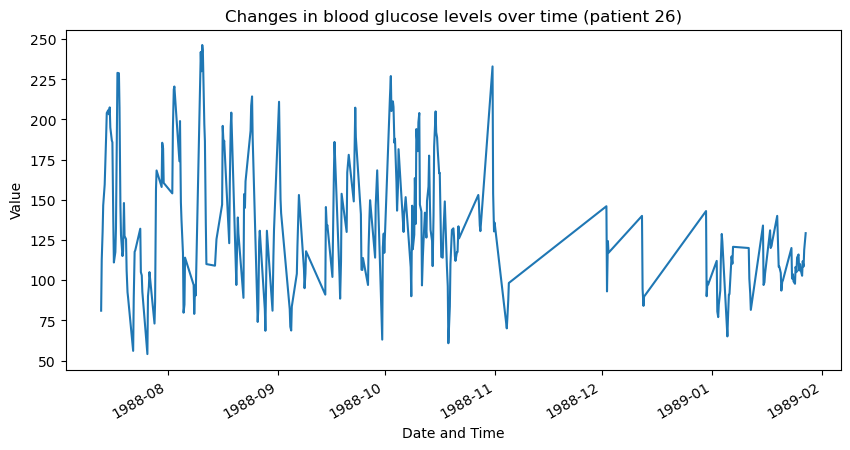

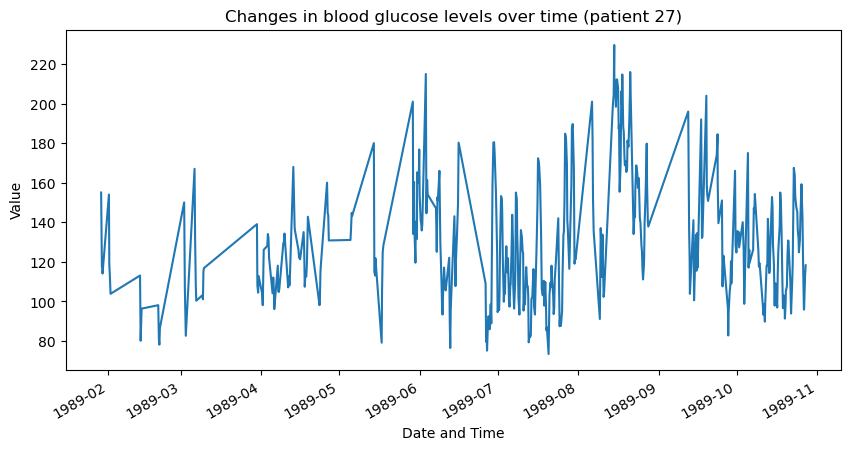

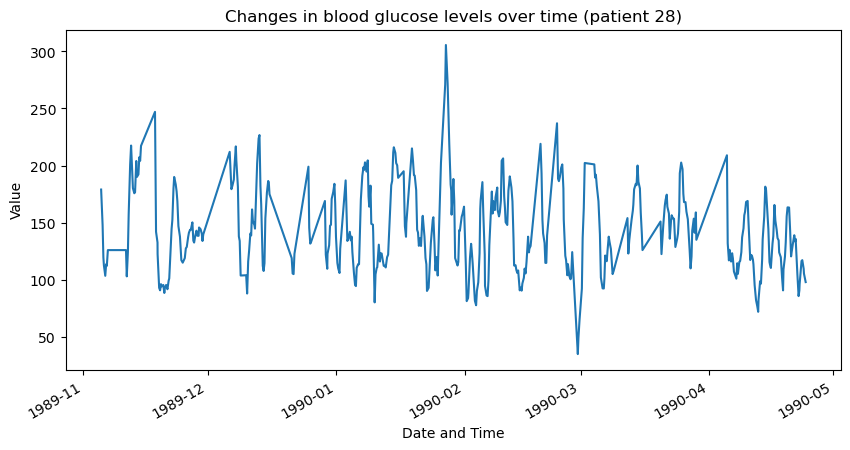

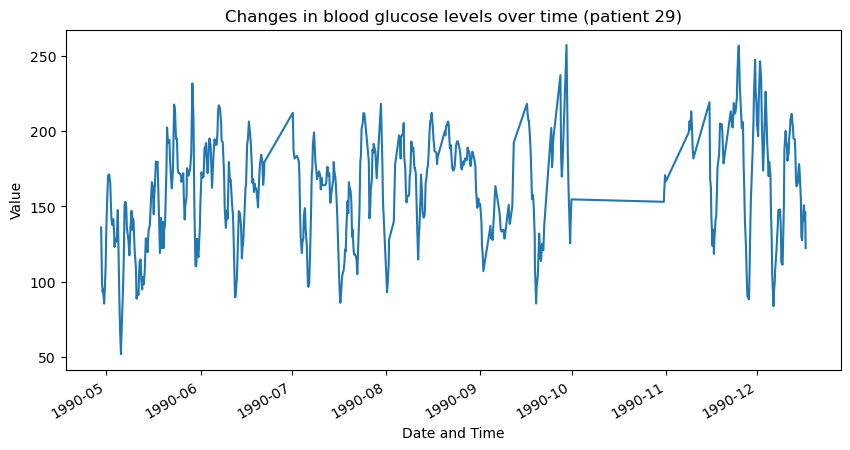

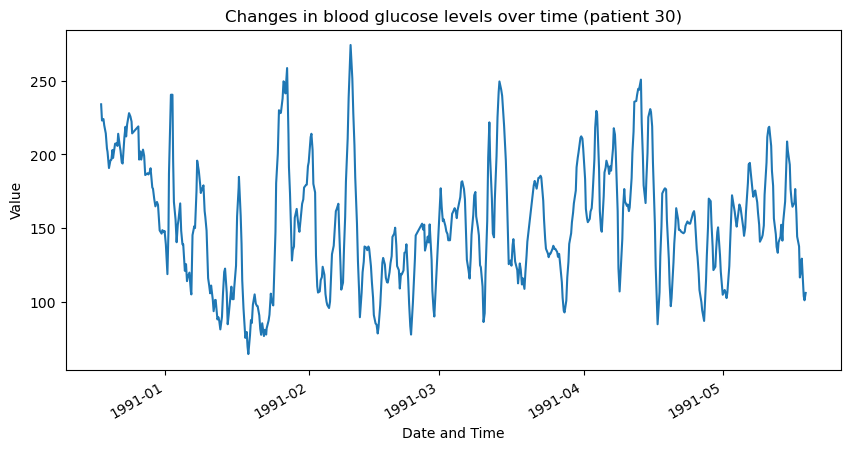

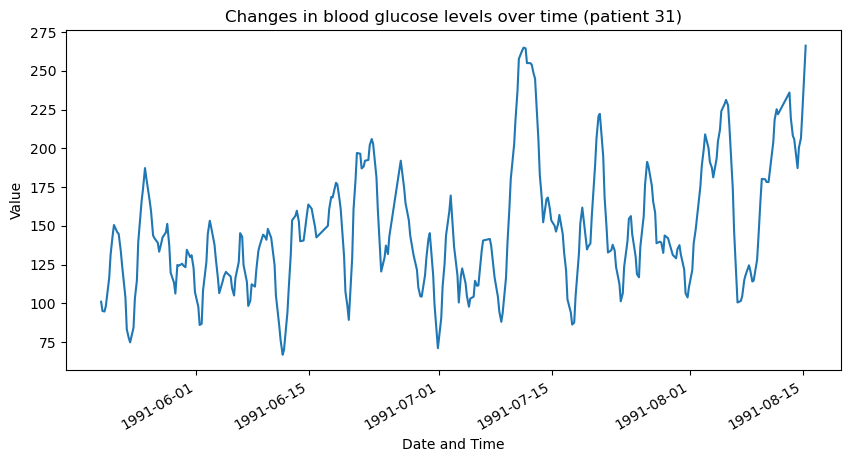

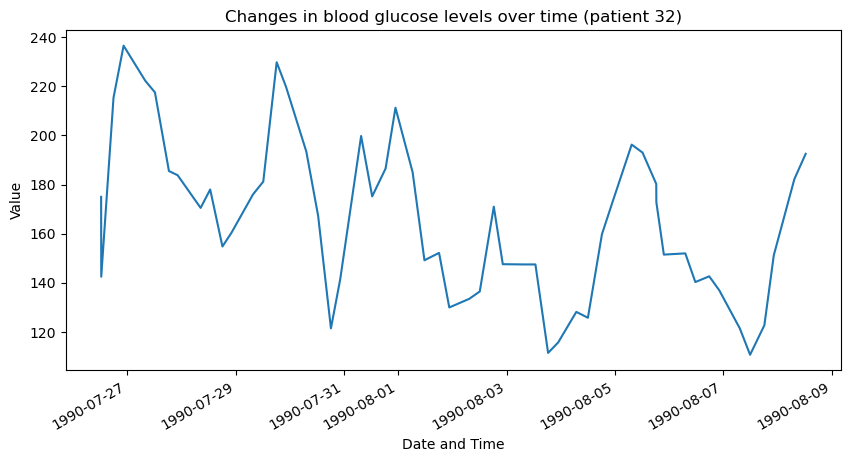

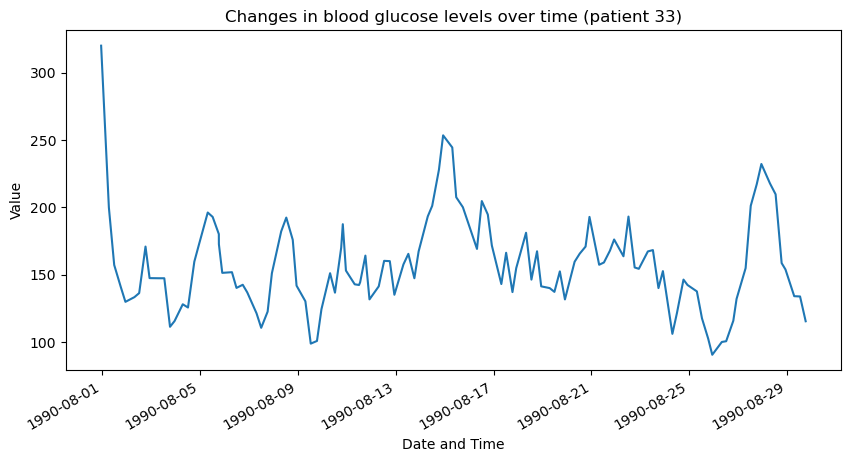

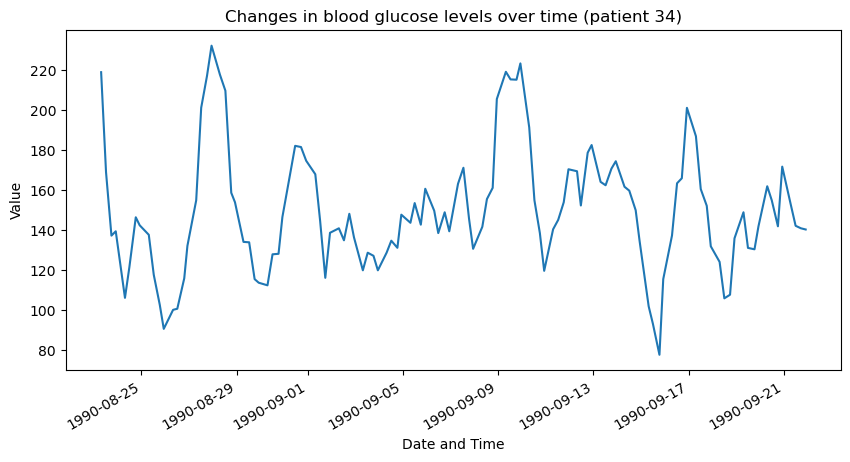

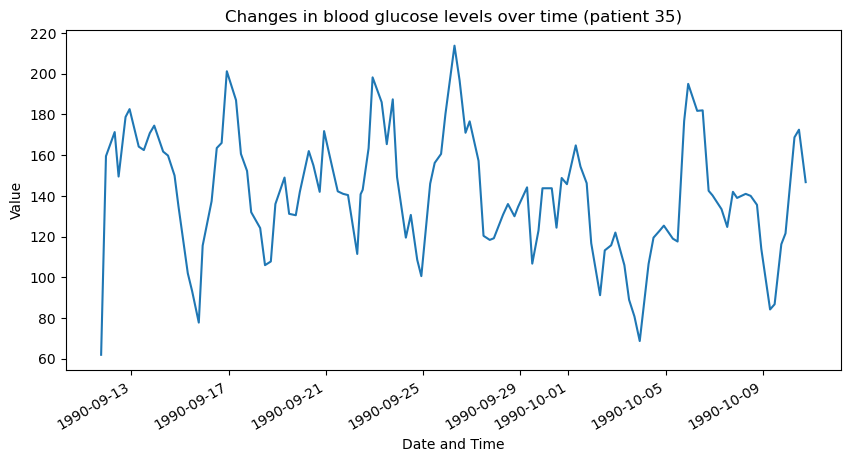

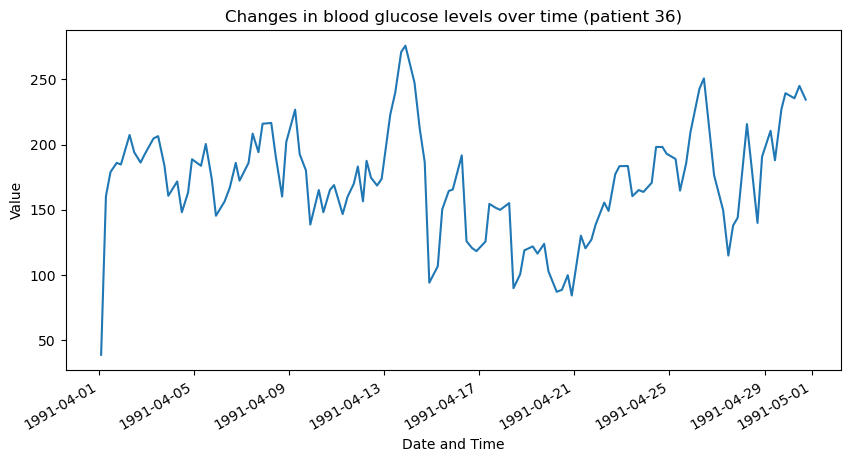

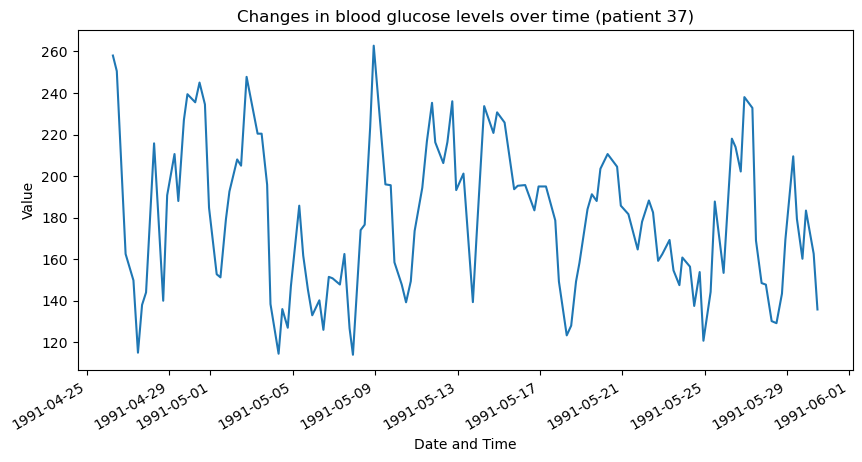

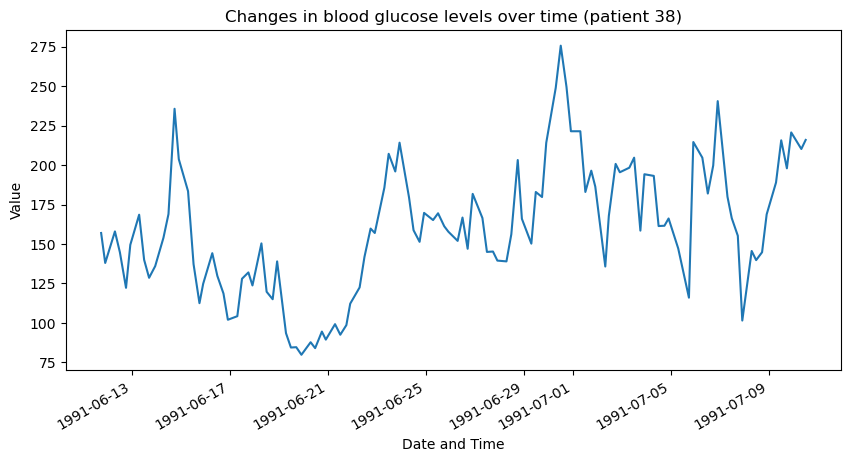

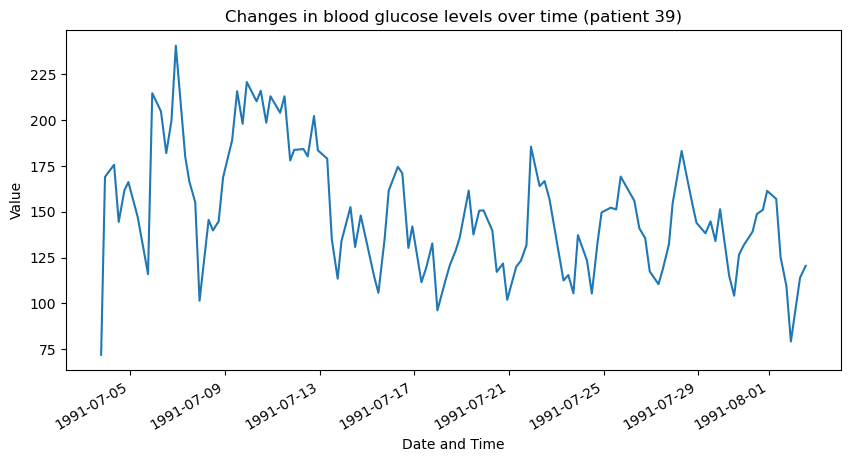

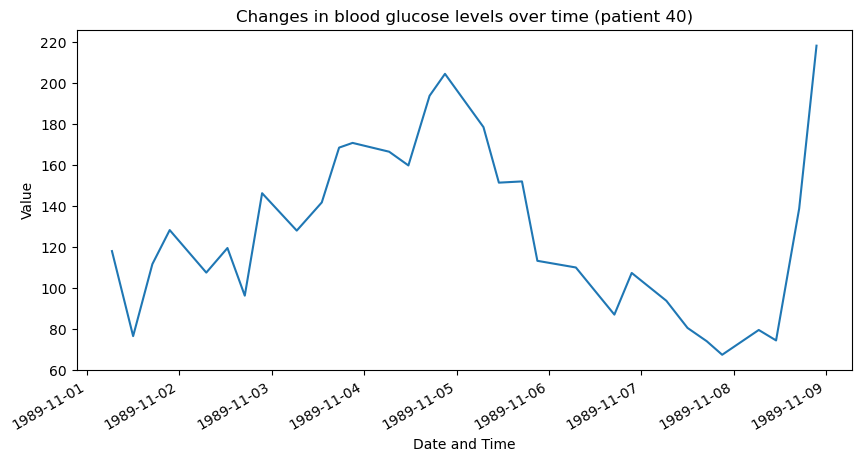

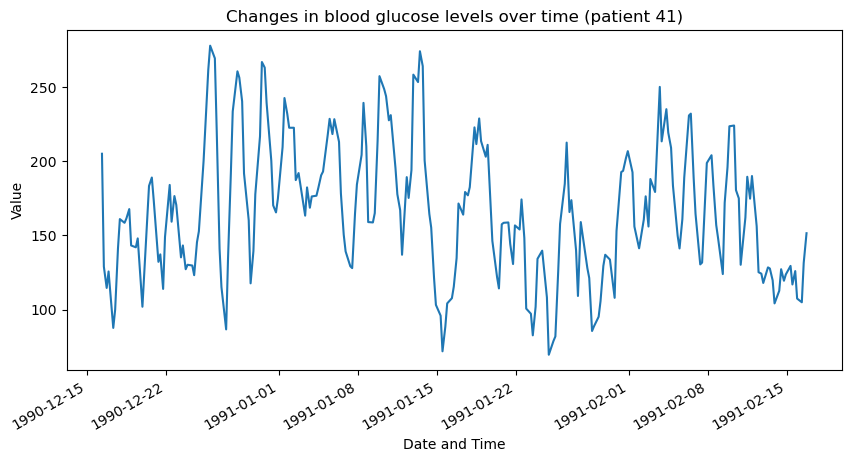

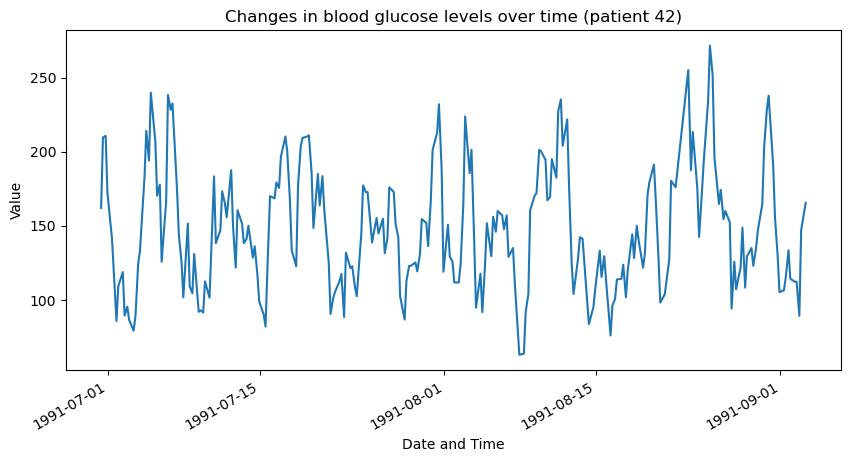

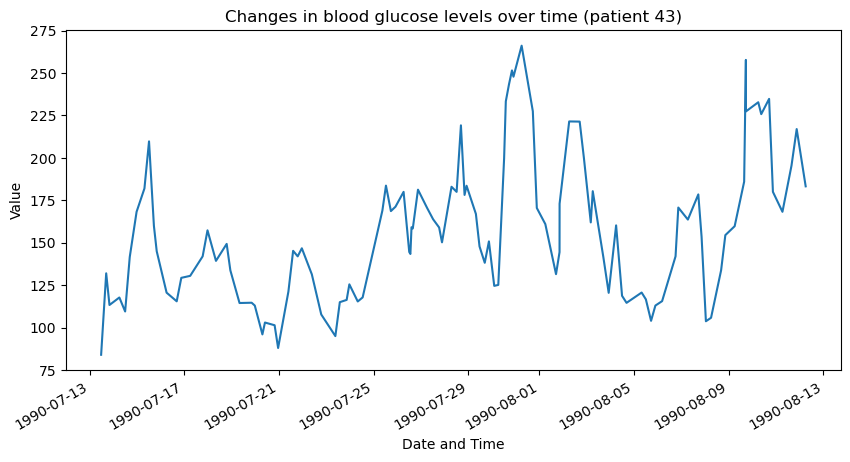

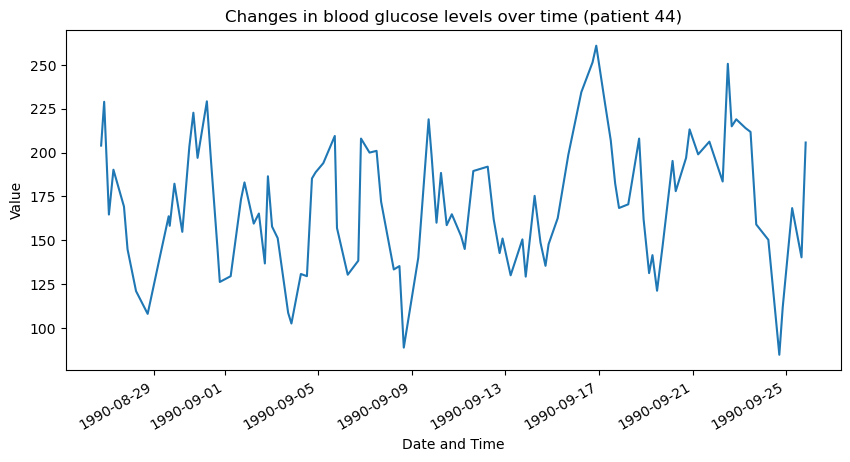

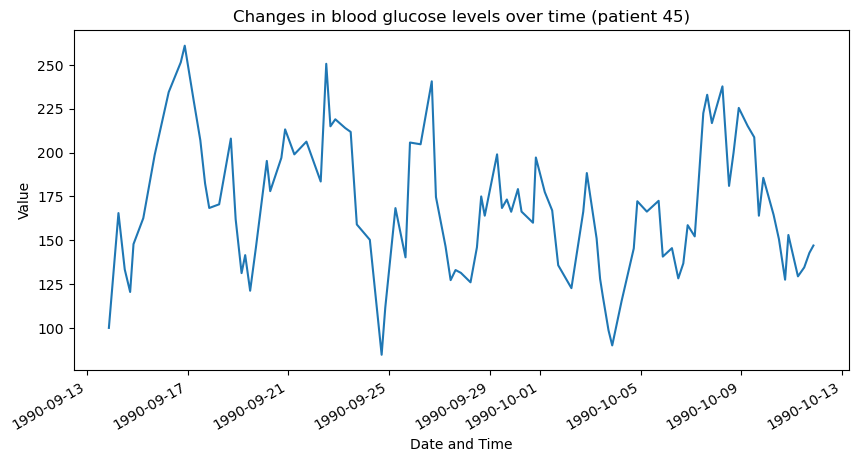

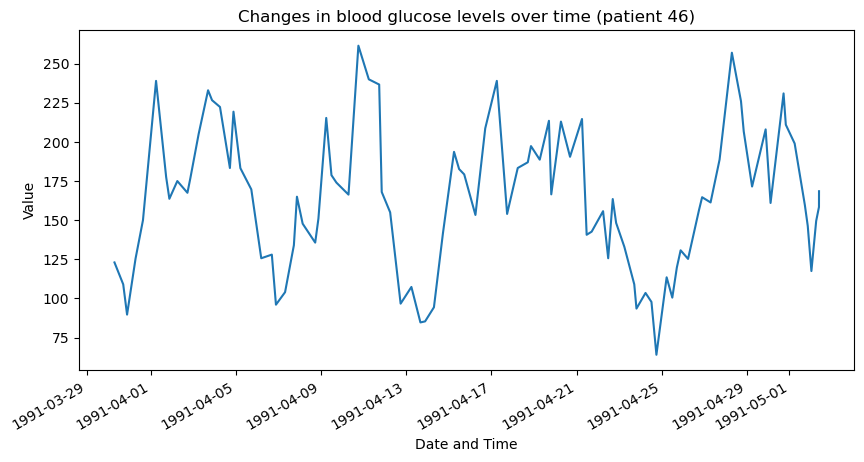

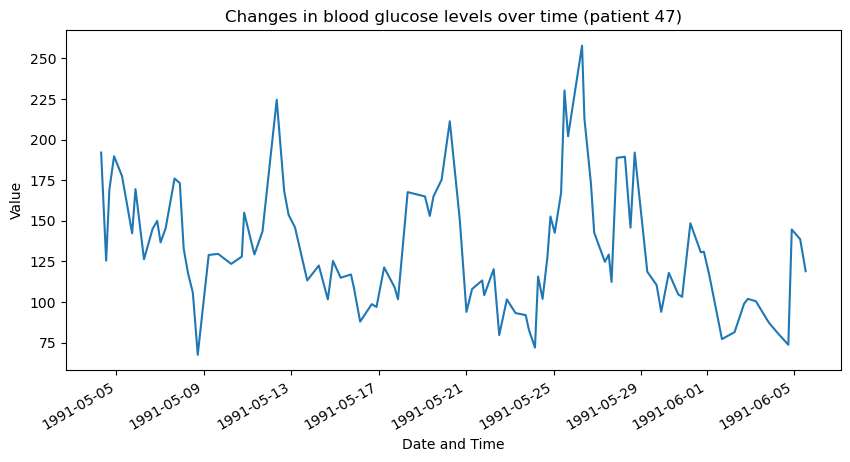

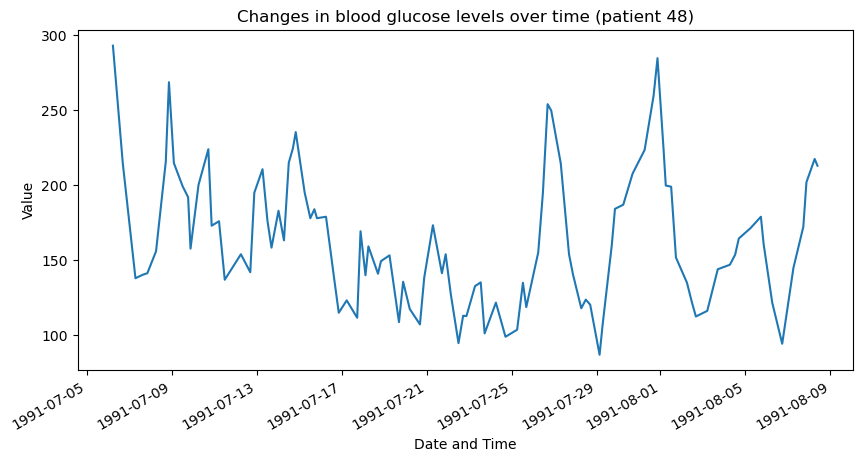

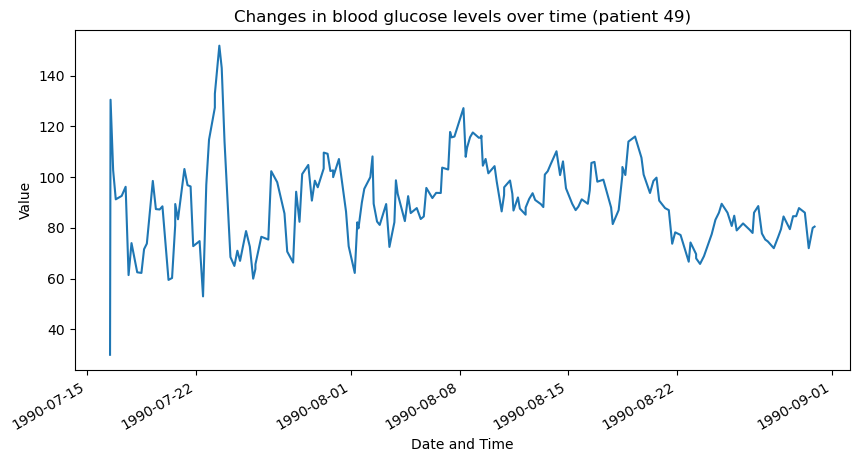

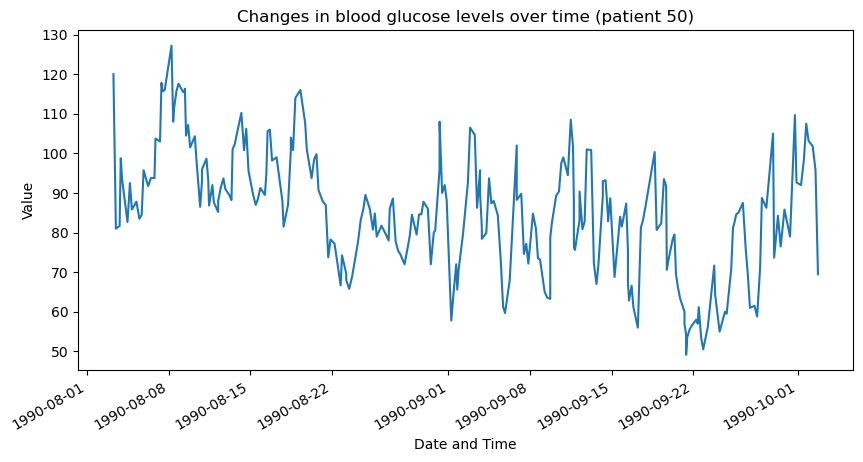

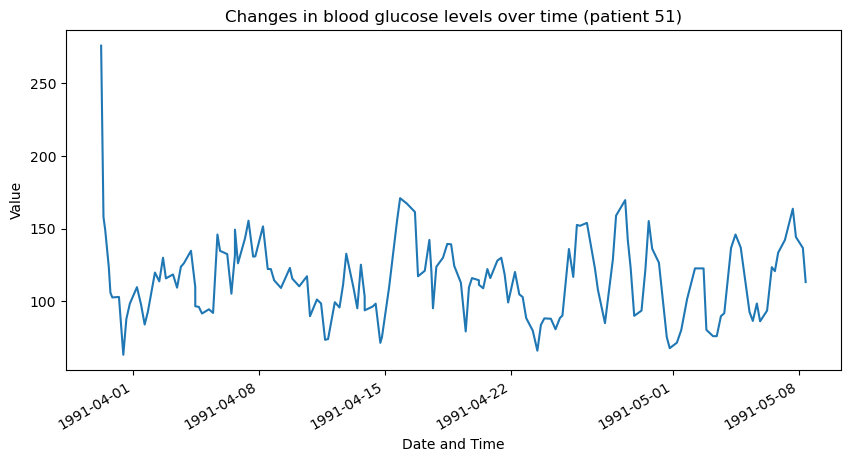

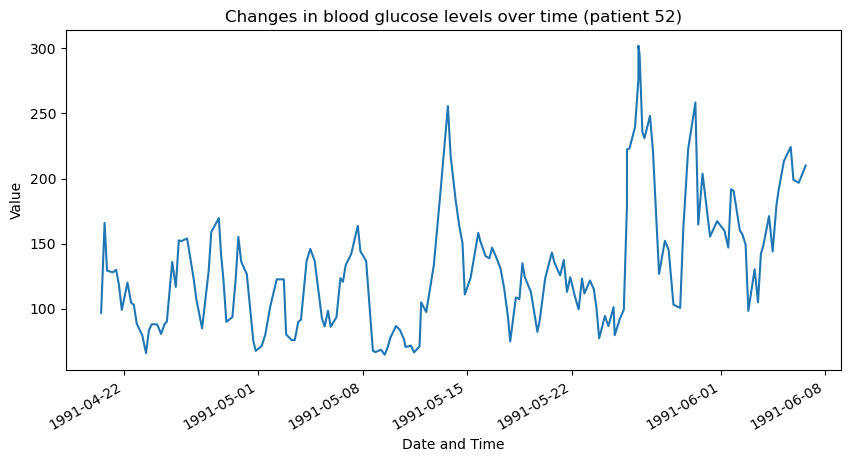

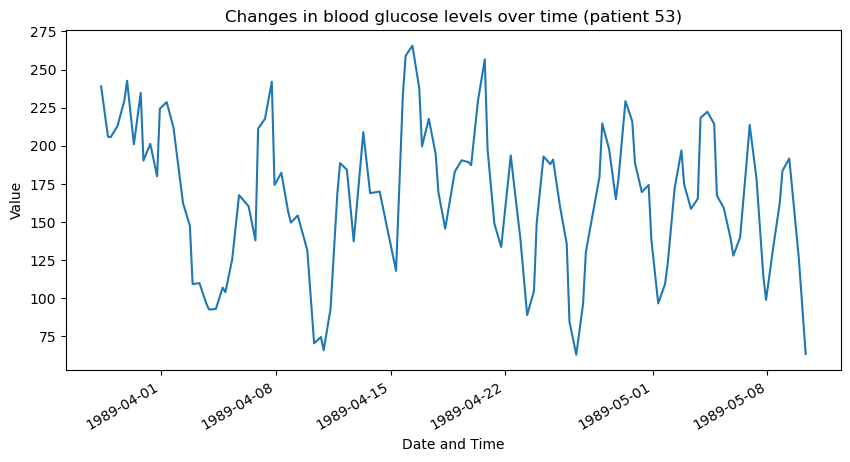

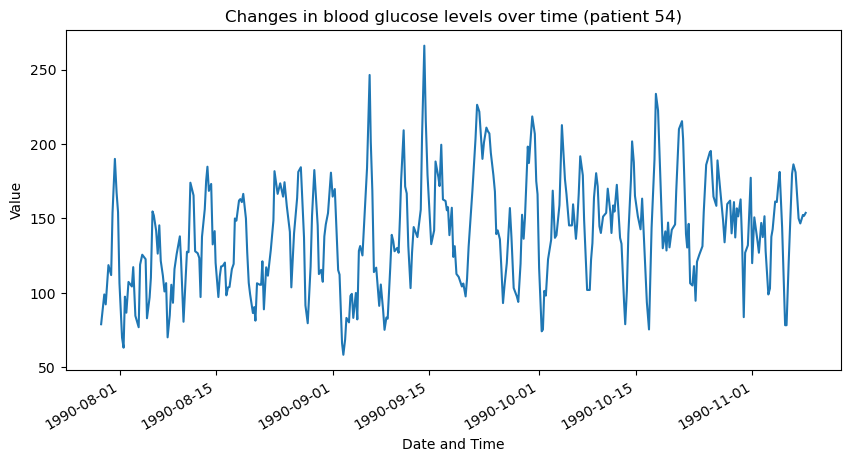

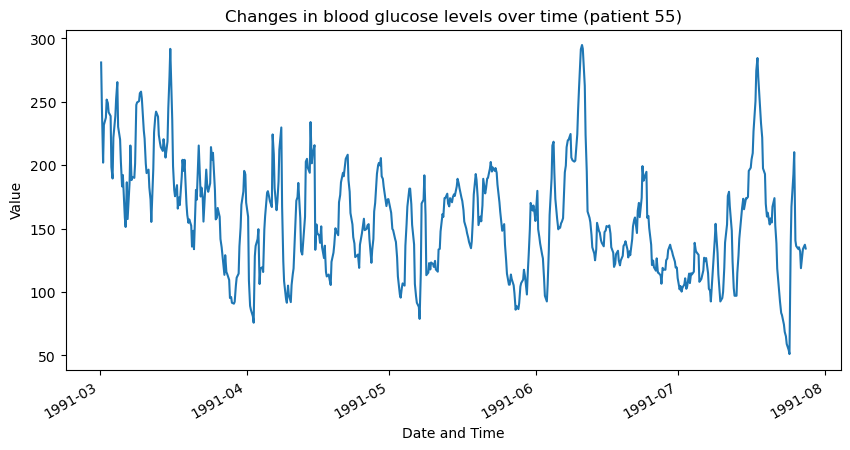

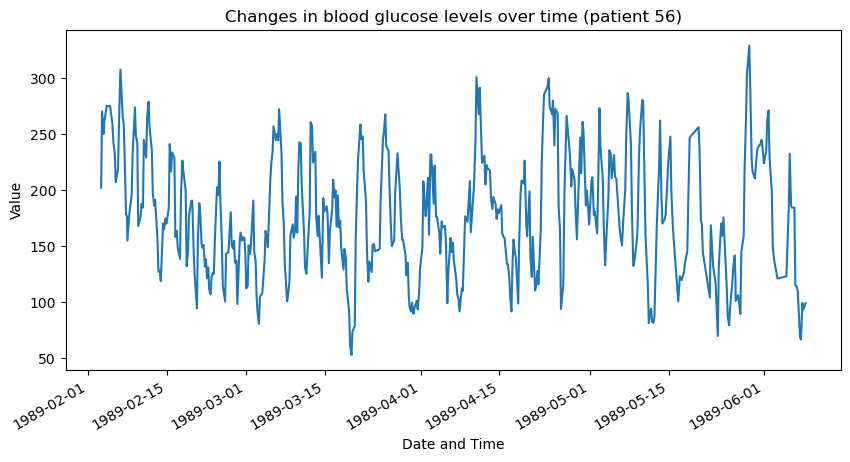

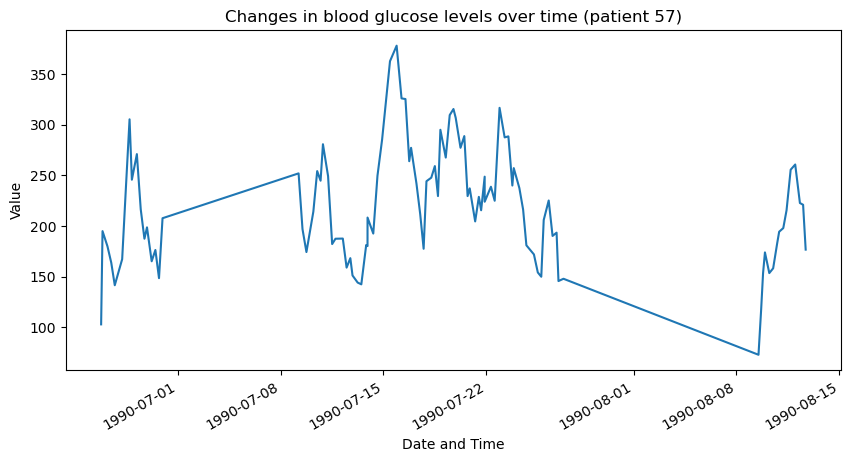

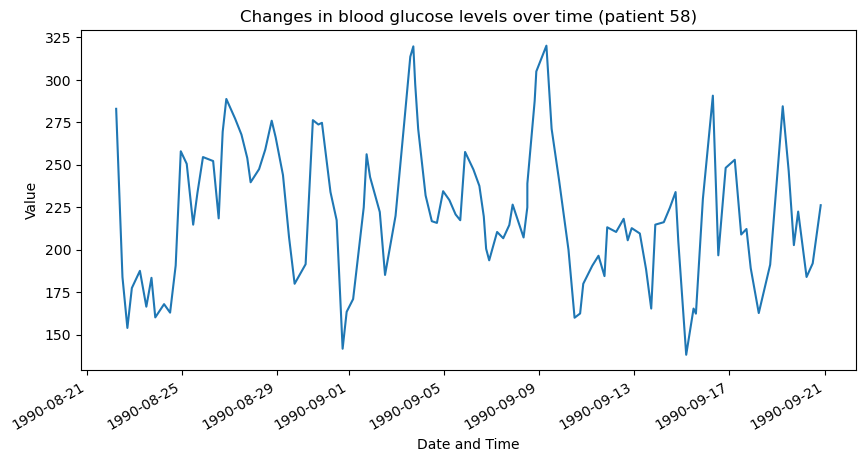

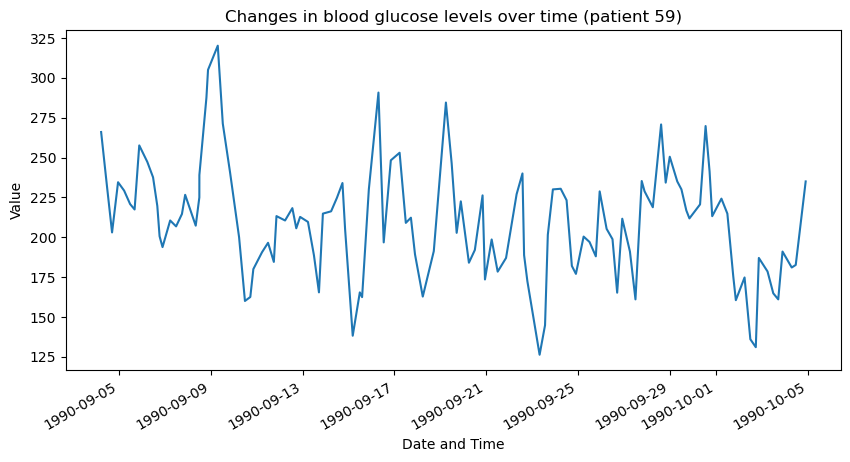

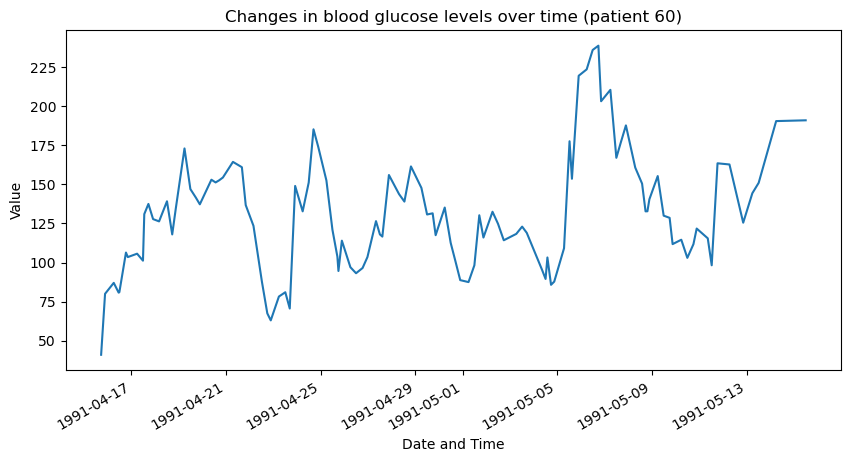

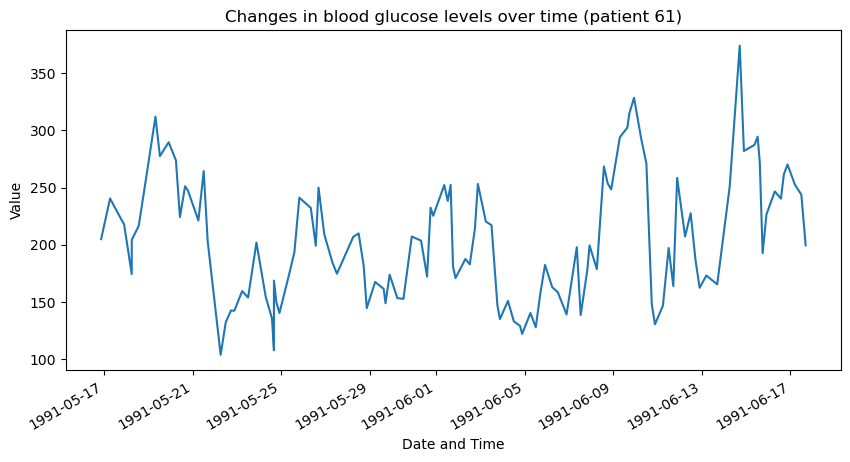

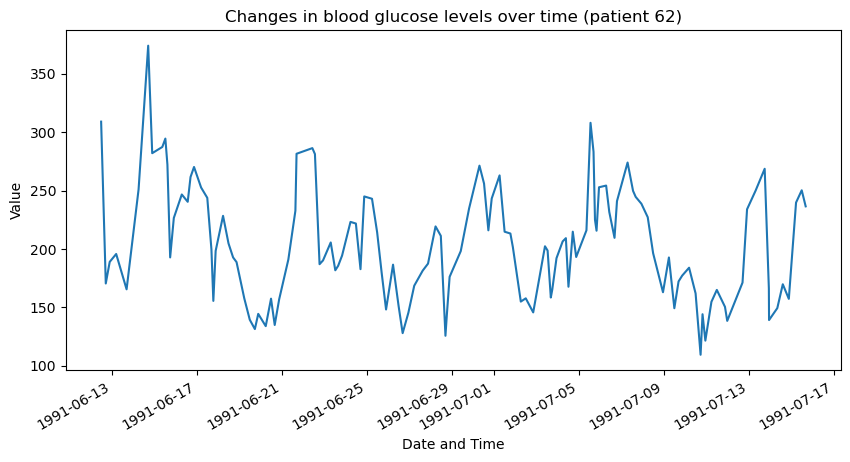

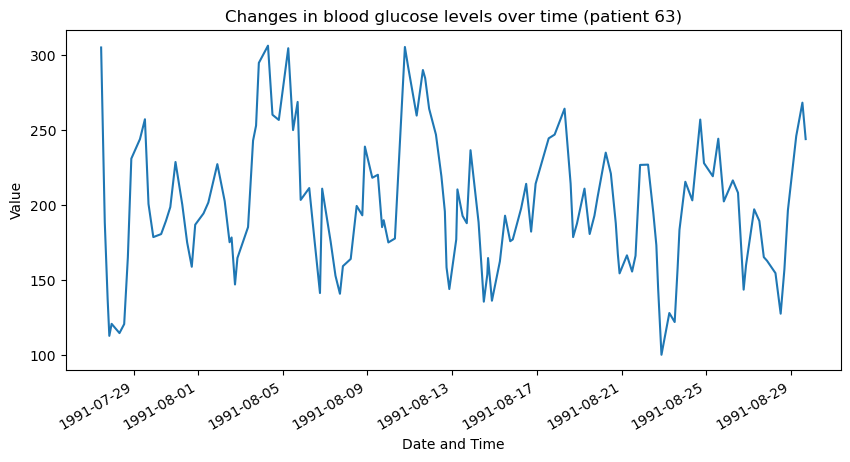

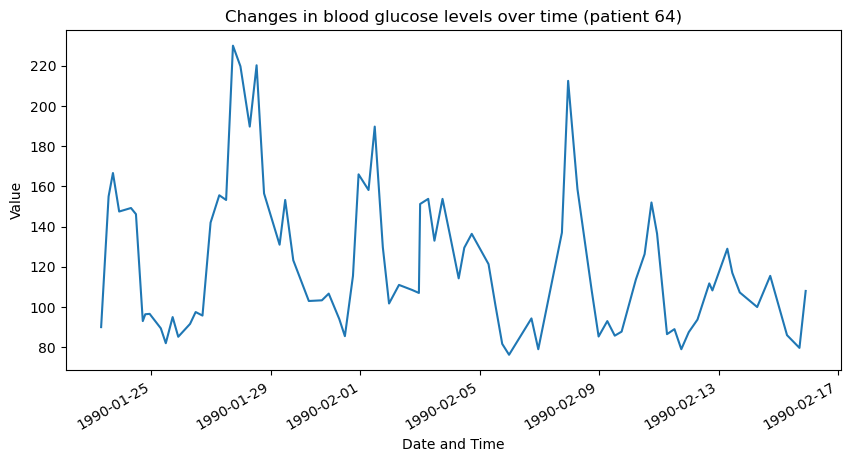

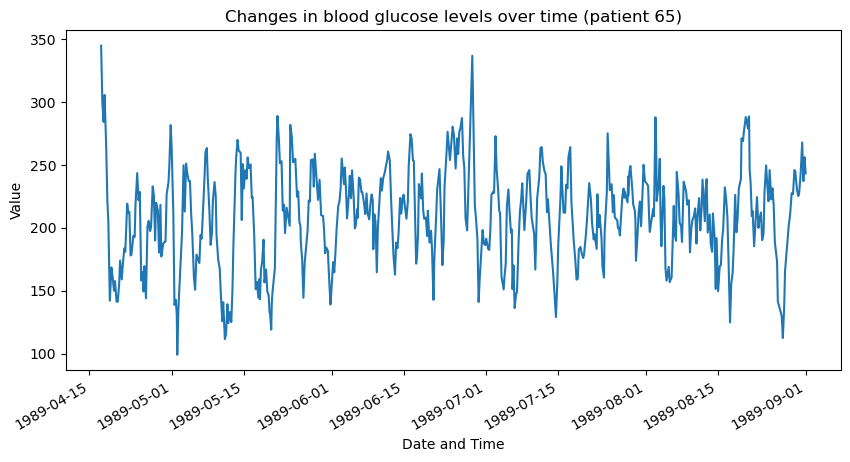

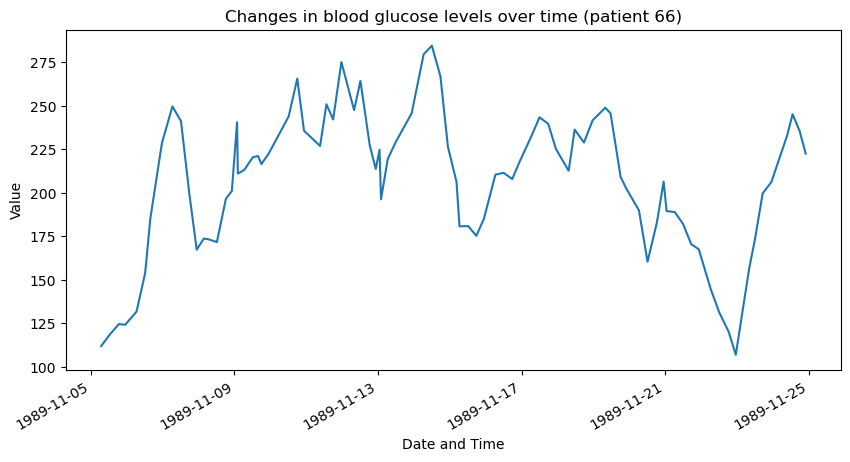

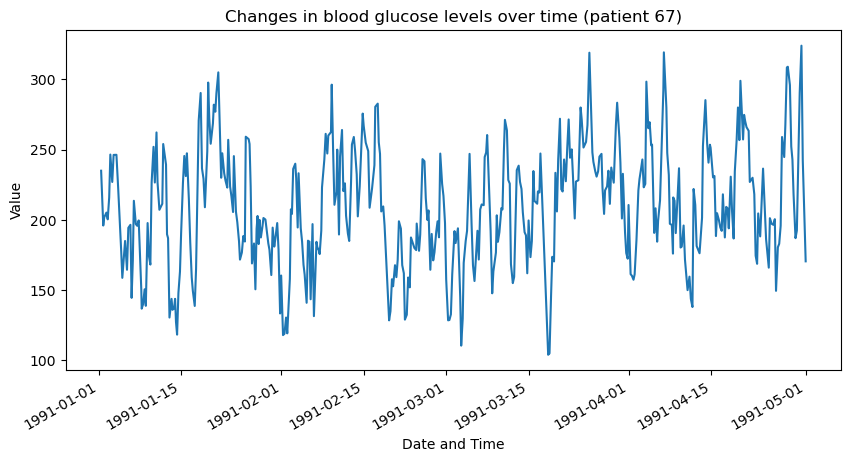

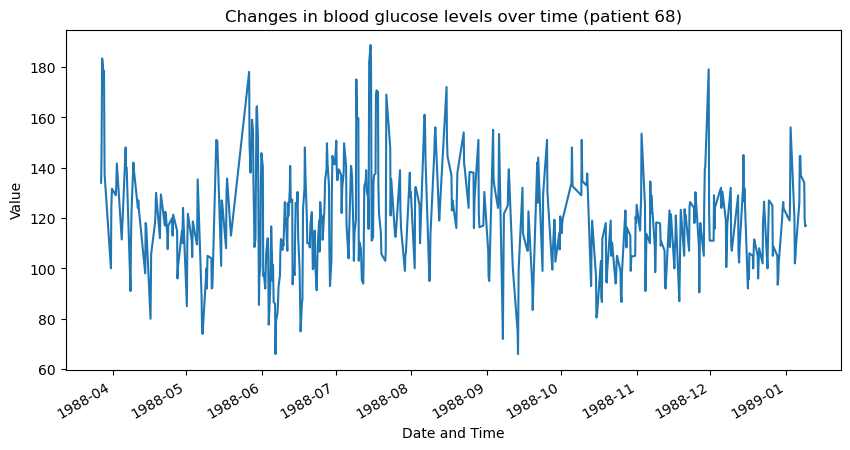

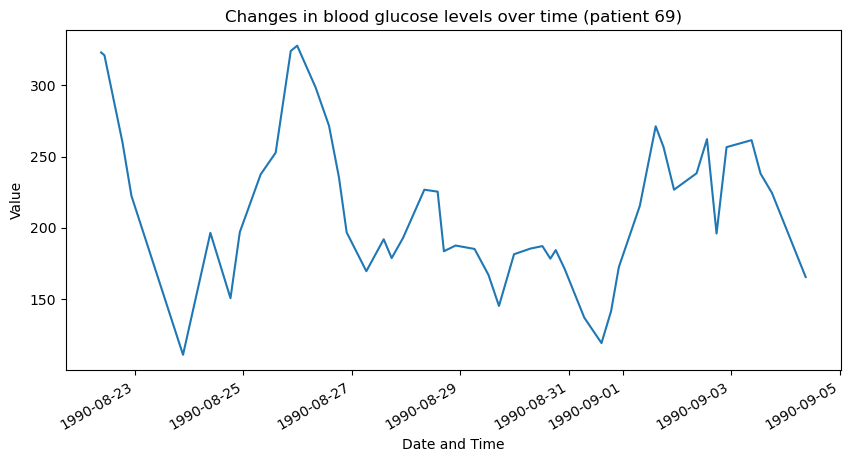

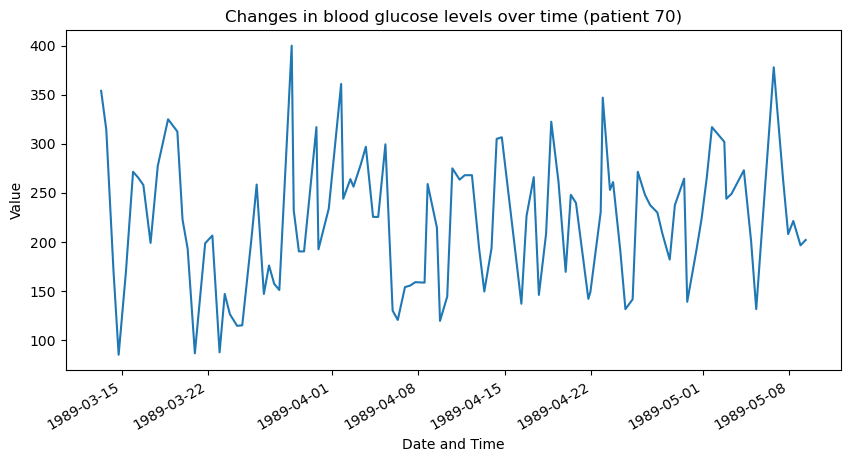

In [971]:
#Data visualization
#Variation in blood glucose levels over time for each patient (moving average per day)
for patient in range(1, 71):
    # Select data for the current patient
    patient_data = df_bg[df_bg['ID'] == patient]
    
    # Plot patient data with rolling mean
    #patient_data['Value'].plot(figsize=(10, 5))

    patient_data['Value'].rolling('D').mean().plot(figsize=(10, 5))
    plt.xlabel("Date and Time")
    plt.ylabel("Value")
    plt.title(f"Changes in blood glucose levels over time (patient {patient})")
    #plt.figure(figsize=(30,22))
    plt.show()

**The data have an irregular interval and we want to make a prediction every Day, so we'll make the data regular.**

In [972]:
 # Resample to daily window
df_resample = df_bg[["ID","Value"]].resample("D").mean().fillna(method='ffill').sort_values(by=['ID'])


In [973]:
#Summary statistics
df_resample['Value'].describe()

count    1276.000000
mean      155.698527
std        36.237180
min        60.750000
25%       129.404762
50%       152.328571
75%       180.250000
max       301.666667
Name: Value, dtype: float64

**These statistics give us the following information:**

    1.The average blood glucose for the patients is 155.698527
    2.25% of patients have a blood glucose value below 129.404762
    3.50% of patients have a blood glucose value below 152.328571
    4.75%  of patients have a blood glucose value below 180.250000
 

Text(0.5, 1.0, 'blood glucose distribution histogram')

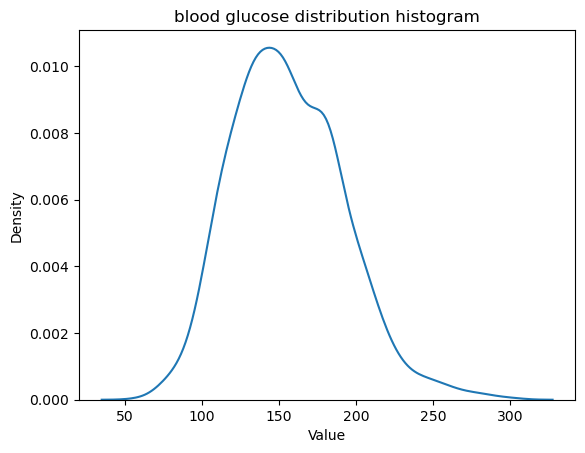

In [974]:
#blood glucose distribution histogram
sns.kdeplot(data=df_resample, x="Value")
plt.title("blood glucose distribution histogram")

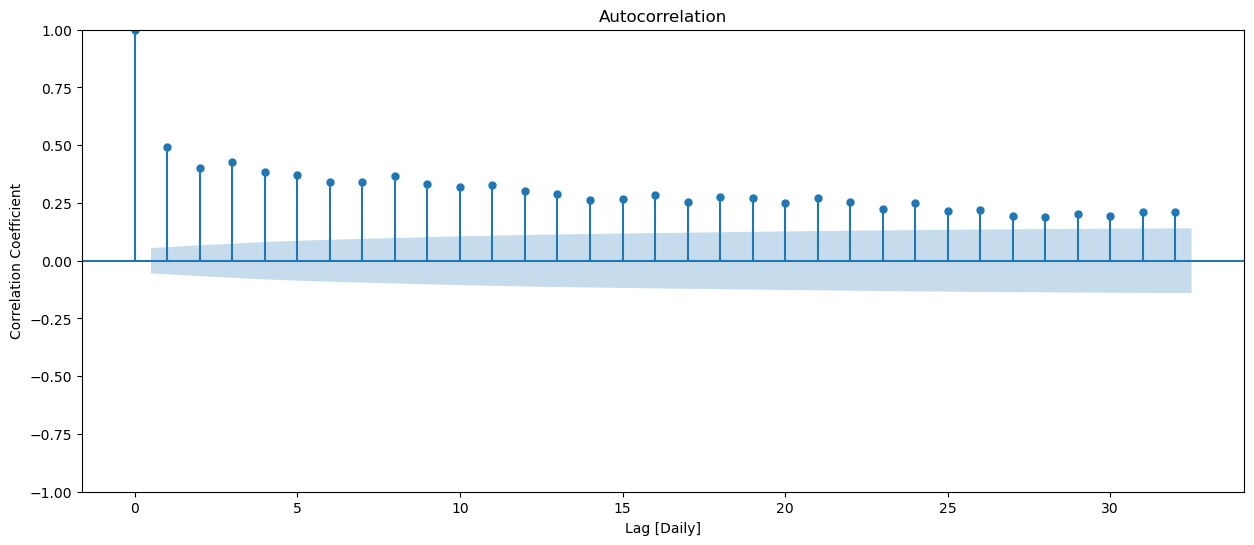

In [975]:
#ACF PLOT
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(df_resample['Value'], ax = ax)
plt.xlabel("Lag [Daily]")
plt.ylabel("Correlation Coefficient");

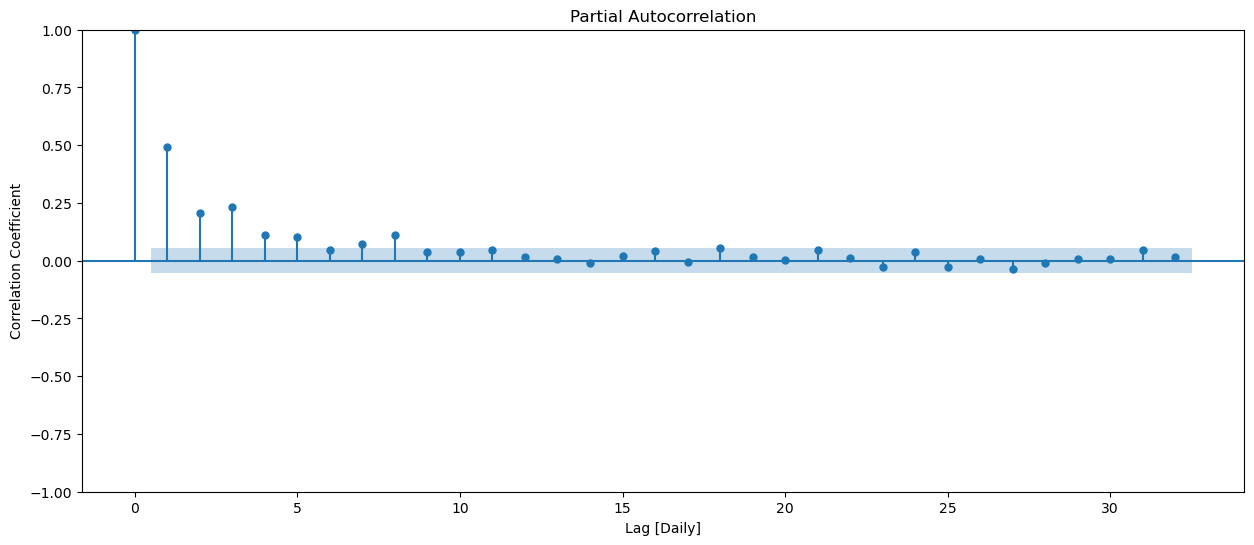

In [976]:
#PACF plot
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(df_resample['Value'], ax = ax)
plt.xlabel("Lag [Daily]")
plt.ylabel("Correlation Coefficient");

In [977]:
#Lag feature 
df_resample["Value_D"] = df_resample["Value"].shift(1)
#Drop NA ROWS
df_resample.dropna(inplace = True)

In [978]:
#Correlation Matrix
df_resample_copy = df_resample.copy()
df_resample.drop(columns="ID").corr()

Value   Value_D
Value    1.000000  0.493293
Value_D  0.493293  1.000000

In [979]:
df_resample["Value_D"]

datetime
1989-12-26    116.50
1989-12-23    178.00
1989-12-22    130.75
1989-12-20    160.75
1989-12-19    176.75
               ...  
1988-12-23    127.00
1988-12-22    126.50
1988-12-21    126.50
1989-01-04    108.00
1988-03-27    108.25
Name: Value_D, Length: 1275, dtype: float64

Text(0.5, 1.0, 'BG autocorrelation plot')

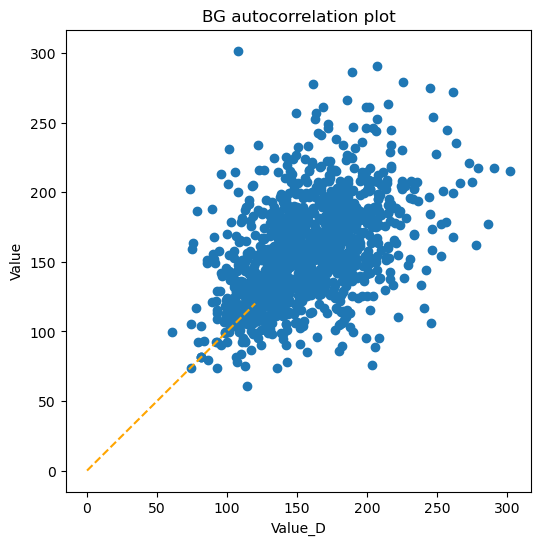

In [980]:
#Scatter plot of autocorrelation 
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x = df_resample["Value"], y = df_resample["Value_D"])
ax.plot([0,120], [0,120], linestyle = "--", color = "orange")
plt.xlabel("Value_D")
plt.ylabel("Value")
plt.title("BG autocorrelation plot")

#### I.3 Split Data

In [981]:
target = "Value"
y = df_resample[target]
X = df_resample["Value_D"]

In [982]:
cutoff = int(len(X) * 0.9)

X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

### II.Build Model

### **In this project we're dealing with time series, so we'll be trying out linear regression and autoregression models.**

#### II.1 Baseline

In [983]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean BG:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean BG: 159.67
Baseline MAE: 28.33


#### II.2 Iteration : 

**LinearRegression**

In [984]:
model = LinearRegression()
model.fit(X_train.values.reshape(-1,1), y_train)

LinearRegression()

In [985]:
model

LinearRegression()

### II.3 Evaluation

In [986]:
training_mae = mean_absolute_error(y_train, model.predict(X_train.values.reshape(-1,1)))
test_mae = mean_absolute_error(y_test, model.predict(X_test.values.reshape(-1,1)))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 24.8
Test MAE: 25.04


In [987]:
#len(model.predict(X_test.values.reshape(-1,1)))

### Communicate Results

In [988]:
#Extraction of y-intercept and model coefficient.
intercept = model.intercept_
coefficient = model.coef_

print(f"Value = {intercept} + ({coefficient} * Value.D)")

Value = 89.58079587449195 + ([0.43892765] * Value.D)


In [992]:
len(model.predict(X_test.values.reshape(-1,1)))

128

In [994]:
#Prediction
df_pred_test = pd.DataFrame({
  "ID" : df_resample_copy["ID"].iloc[1147:],
  "y_test" : y_test,
  "y_pred" : model.predict(X_test.values.reshape(-1,1))
})

df_pred_test["patient_status"]=["High BG Increasing over time" if pred > 200 else "Low BG decreasing over time" 
                                if pred <= 80 else "Normal BG." for patient, pred in zip(df_pred_test.ID, df_pred_test.y_pred)]

df_pred_test.head()

ID      y_test      y_pred patient_status
datetime                                               
1988-04-09  68.0  138.666667  132.815170     Normal BG.
1988-04-10  68.0  138.666667  150.445430     Normal BG.
1988-09-10  68.0  139.333333  150.445430     Normal BG.
1988-09-09  68.0  139.333333  150.738049     Normal BG.
1988-04-11  68.0  123.333333  150.738049     Normal BG.